In [12]:
import hddm
import sys
import pandas as pd
import numpy as np
import sys

sys.path.append('simulators')
import cddm_data_simulation as cds
import boundary_functions as bf

def ddm_make(model_name, #'ddm', 'angle' or 'weibull_cdf'
             n_samples, #number of samples
             v, #drift rate
             a, #boundary separation
             w, #between 0.5 and 1
             ndt, #non-decision time,
             alpha = 1, #parameter for weibull cdf, default is 1,
             beta = 1, #parameter for weibull cdf, default is 1,
             theta = 0.5): #angle parameter

    #Initialise parameters of the simulator
    if model_name == 'ddm':
        boundary_funcP = bf.constant
        boundary_multP = True
        boundary_paramP = {}
    elif model_name == 'angle':
        boundary_funcP = bf.angle
        boundary_multP = False
        boundary_paramP = {'theta': theta}
    elif model_name == 'weibull_cdf':
        boundary_funcP = bf.weibull_cdf
        boundary_multP = True
        boundary_paramP = {'alpha': alpha, 'beta': beta}
        
    #Simulate data
    data = cds.ddm_flexbound(v = v,
                             a = a,
                             w = w,
                             ndt = ndt,
                             delta_t = 0.01,
                             s = 1,
                             max_t = 20,
                             n_samples = n_samples,
                             boundary_fun = boundary_funcP,
                             boundary_multiplicative = boundary_multP,
                             boundary_params = boundary_paramP)

    #Process data into shape friendly with hddm
    df = pd.DataFrame(data[0].astype(np.double), columns = ['rt'])
    df['response'] = data[1].astype(int)
    df['nn_response']=df['response']
    df.loc[df['response'] == -1.0, 'response'] = 0.0
    df['subj_idx'] = 0
    
    #Run HDDM
    if model_name == 'angle':
        m = hddm.HDDMnn_angle(df,free = False, informative=False,include='z',is_group_model = False)
    elif model_name =='weibull_cdf':
        #weibull
        # free=False means that parameters specific for the model is bound to the ranges used to train the neural network
        # informative=False does the same, but for the standard DDM-parameters. 
        # k=True means that you estimate alpha in the weibull-model. If k=False it is set to have a fixed value of 3
        model_name ='weibull'
        m = hddm.HDDMnn_weibull(df,free=False,informative=False,k=True,include='z',is_group_model = False)
    elif model_name == 'ddm':
        m = hddm.HDDMnn(df,informative=False,include='z', is_group_model = False)
    
    #Draw samples
    tobeDrawn = round(1000)
    tobeSampled = round(tobeDrawn * 0.8)
    tobeBurnt = tobeDrawn - tobeSampled
    print(tobeDrawn)
    print(tobeSampled)
    print(tobeBurnt)
    m.sample(tobeSampled,burn= tobeBurnt ,dbname='traces.db',db='pickle')
    
    #Post predictive checks
    # tracedf = m.get_traces()
    # if model_name == 'angle':
    #     for i in range(min(tracedf.shape[0], 500)): #loop through the trace
    #         locator = tracedf.iloc[i]
    #         data_temp = cds.ddm_flexbound(v = locator['v'], #simulate data from trace
    #                   a = locator['a'],
    #                   w = locator['z_trans'],
    #                   ndt = locator['t'],
    #                   delta_t = 0.01,
    #                   s = 1,
    #                   max_t = 20,
    #                   n_samples = n_samples,
    #                   boundary_fun = boundary_funcP,
    #                   boundary_multiplicative = boundary_multP,
    #                   boundary_params = {'theta': locator['theta']})
    #         m = hddm.HDDMnn_angle(df,free = False, informative=False,include='z',is_group_model = False) #fit
    # elif model_name == 'weibull_cdf':
    #     for i in range(min(tracedf.shape[0], 500)):
    #         locator = tracedf.iloc[i]
    #         data_temp = cds.ddm_flexbound(v = locator['v'],
    #                   a = locator['a'],
    #                   w = locator['z_trans'],
    #                   ndt = locator['t'],
    #                   delta_t = 0.01,
    #                   s = 1,
    #                   max_t = 20,
    #                   n_samples = n_samples,
    #                   boundary_fun = boundary_funcP,
    #                   boundary_multiplicative = boundary_multP,
    #                   boundary_params = {'alpha': locator['alpha'], 'beta': locator['beta']})
    # elif model_name == 'ddm':
    #     for i in range(min(tracedf.shape[0], 500)):
    #         locator = tracedf.iloc[i]
    #         data_temp = cds.ddm_flexbound(v = locator['v'],
    #                   a = locator['a'],
    #                   w = locator['z_trans'],
    #                   ndt = locator['t'],
    #                   delta_t = 0.01,
    #                   s = 1,
    #                   max_t = 20,
    #                   n_samples = n_samples,
    #                   boundary_fun = boundary_funcP,
    #                   boundary_multiplicative = boundary_multP,
    #                   boundary_params = {})
        
    

        
    return m

answer = ddm_make('angle', 1000, 0.5, 1.5, 0.6, 0.5, theta = 0.3)

1000
800
200
 [-----------------100%-----------------] 800 of 800 complete in 26.6 sec

In [21]:
answer.gen_stats()

,mean,std,2.5q,25q,50q,75q,97.5q,mc err
a,1.52743,0.0522486,1.42721,1.48932,1.52841,1.56751,1.63245,0.00463054
v,0.548564,0.0435202,0.465277,0.519065,0.547047,0.576282,0.637771,0.00320397
t,0.504199,0.0240219,0.455105,0.488076,0.503721,0.521525,0.547769,0.0020522
z,0.579711,0.0142921,0.551979,0.570477,0.581226,0.590131,0.605189,0.00114912
theta,0.2939,0.0244534,0.24476,0.276357,0.292931,0.313823,0.337482,0.00209245


In [14]:
import matplotlib.pyplot as plt


(array([  7.,  43.,  62.,  88., 144., 130.,  88.,  32.,   5.,   1.]),
 array([0.15850976, 0.1938415 , 0.22917324, 0.26450497, 0.29983671,
        0.33516845, 0.37050019, 0.40583193, 0.44116367, 0.47649541,
        0.51182715]),
 <a list of 10 Patch objects>)

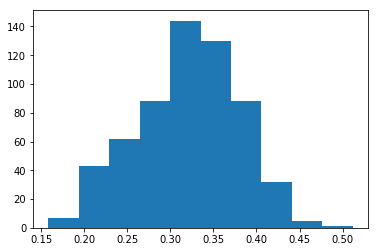

In [20]:
plt.hist(answer.get_traces()['z_trans'])